### Learning the Thermodynamics of Liquid Hafnium by using Bayesian methods!

This assignment was based on the work of Paulson et al. (2019) who learned thermodynamic models for the phases of liquid Hafnium. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import kombine

##### Loading two datasets from Paulson et al. 2019 via Pandas: 

In [2]:
h_data = pd.read_csv('data/Cag2008.csv', delim_whitespace=True)
cp_data = pd.read_csv('data/Kor2005.csv', delim_whitespace=True)

NOTE: For reference, the unit of temperature $T$ is K, specific heat capacity $C_p$ is J mol<sup>-1</sup> K<sup>-1</sup>, and enthalpy $H$ is J mol<sup>-1</sup>.
The datasets contain the value of the property and an uncertainty for the measurement
in the column prefixed with `sigma_`.

#### Building prior distributions of specific heat capacity and enthalpy: 

Representing specific heat capacity as a linear model: $C_p(T) = c_1 + c_2 T$

In [3]:
def spc(c1, c2, T): 
    """ Computing the specific heat capacity as a linear model
    
    Args:  
        c1: the amount of Joules it takes to raise the temperature of one mol of the substance by one Kelvin at a temperature of 0K (y-intercept)
        c2: rate of increase of specific heat as the surrounding temperature increases by 1 Kelvin
        T: given temperature in K in the environment
        
    Returns: 
        The specific heat of the compound at the given temperature
    """
    
    return c1 + (c2 * T)

Representing enthalpy as $H(T) = \int_0^T C_p(T) dT = c_0 + c_1 T + c_2 T^2/2$": 

In [4]:
def enthalpy(c0, c1, c2, T):
    """ Computing the enthalpy of a particular compound """
    
    return c0 + (c1 * T) + (c2 * (T**2 * 1/2))

Fitting an estimate for c1 and c2 by using robust regression on the CP dataset: 

In [5]:
lin_model = stats.siegelslopes(cp_data['Cp'], cp_data['T'])

c1 = lin_model[1]
c2 = lin_model[0]

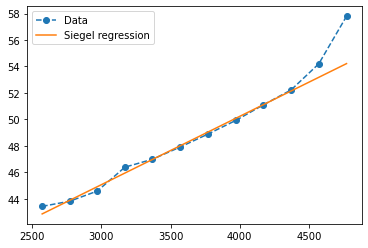

In [6]:
# plotting data and predicted regression

fig, ax = plt.subplots()
ax.plot(cp_data['T'], cp_data['Cp'], '--o', label='Data')
ax.plot(cp_data['T'], lin_model[1] + lin_model[0] * cp_data['T'], label='Siegel regression')
ax.legend()

Finding c0 for each point algebraically and taking the median for an estimate for c0: 

In [7]:
c0 =  h_data['H'] - c1 * h_data['T'] - c2 * (h_data['T'] ** 2 / 2)
c0 = np.median(c0)

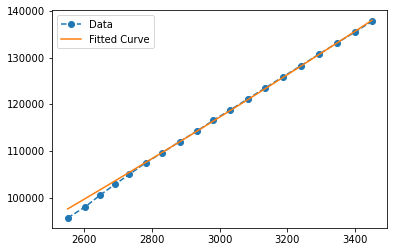

In [8]:
# plotting data and predicted regression

fig, ax = plt.subplots()
ax.plot(h_data['T'], h_data['H'], '--o', label='Data')
ax.plot(h_data['T'], enthalpy(c0, c1, c2, h_data['T']), label='Fitted Curve')
ax.legend()

Constructing prior distributions of c0, c1, and c2 and plotting them via normal distributions: 

In [9]:
c0_prior = stats.norm(loc=c0, scale=c0 * 0.5) 
c1_prior = stats.norm(loc=c1, scale=c1 * 0.5)
c2_prior = stats.norm(loc=c2, scale=c2 * 0.5)

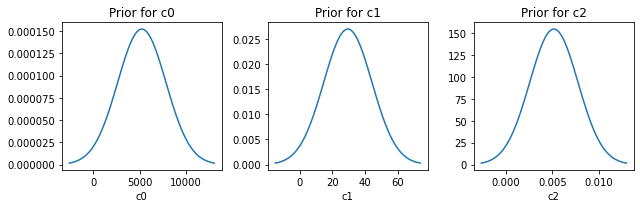

In [10]:
# plotting prior distributions of three parameters
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
r0 = np.linspace(c0-c0*1.5, c0+c0*1.5, 100)
axs[0].plot(r0, c0_prior.pdf(r0))
axs[0].set_title('Prior for c0')
axs[0].set_xlabel('c0')

r1 = np.linspace(c1 - c1 * 1.5, c1 + c1 * 1.5, 100)
axs[1].plot(r1, c1_prior.pdf(r1))
axs[1].set_title('Prior for c1')
axs[1].set_xlabel('c1')

r2 = np.linspace(c2 - c2 * 1.5, c2 + c2 * 1.5, 100)
axs[2].plot(r2, c2_prior.pdf(r2))
axs[2].set_title('Prior for c2')
axs[2].set_xlabel('c2')

plt.tight_layout()
plt.show()

What is the **log** prior probability of $c_0$ = 5000, $c_1$ = 35, and $c_2$ = 0.005?

In [11]:
c0_prior = stats.norm(loc=c0, scale=c0 * 0.5) 
c1_prior = stats.norm(loc=c1, scale=c1 * 0.5)
c2_prior = stats.norm(loc=c2, scale=c2 * 0.5)

In [12]:
# log probability density function of c0
c0_prior.logpdf(5000)

-8.793775331698052

In [13]:
# log probability density function of c1
c1_prior.logpdf(35)

-3.6800646117998674

In [14]:
# log probability density function of c2
c2_prior.logpdf(0.005)

5.038544305498003

Defining a prior distribution for dataset hyperparameters that adjusts the uncertainty values of each dataset

In [15]:
# using a uniform prior distribution that ranges from 0 to 10 with an equal likelihood

alpha_Cp = stats.uniform(loc=0, scale=10)
alpha_H = stats.uniform(loc=0, scale=10)

What is the prior probability of $\alpha_{C_p} = 5$ and $\alpha_H = 11$?

In [16]:
alpha_Cp.pdf(5)

0.1

In [17]:
alpha_H.pdf(11)

0.0

Combining all prior distributions into one list: 

In [18]:
priors = [
    stats.norm(loc=c0, scale=c0 * 0.5), 
    stats.norm(loc=c1, scale=c1 * 0.5),
    stats.norm(loc=c2, scale=c2 * 0.5),
    stats.uniform(loc=0, scale=10),
    stats.uniform(loc=0, scale=10)   
]

#### Defining the Likelihood Function: 

In [19]:
class Posterior:
    """Posterior probability of liquid H thermodynamic models
    
    Assumes parameters are in the order: c_0, c_1, c_2, alpha_cp, alpha_h
    """
    
    def __init__(self, cp_data, h_data, priors):
        """Initialize the class
        
        Args:
            cp_data: Heat capacity data
            h_data: Enthalpy data
            prior: Prior distributions for each parameter
        """
        self.cp_data = cp_data
        self.h_data = h_data
        self.priors = priors
        
    def logprob_cp_data(self, params):
        """Compute the log probability of observing the C_p data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        ## taking the sum of the log-likelihoods of observing the model given parameters
        cp_pred = spc(params[1], params[2], cp_data['T'])
        cp_error = cp_data['Cp'] - cp_pred
        
        return stats.norm(0, scale=cp_data['sigma_Cp']).logpdf(cp_error).sum() # standard deviation determined by uncertainty value
    
    def logprob_h_data(self, params):
        """Compute the log probability of observing the H data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        ## taking the sum of the log-likelihoods of observing the model given parameters
        h_pred = enthalpy(params[0], params[1], params[2], h_data['T'])
        h_error = h_data['H'] - h_pred
        
        return stats.norm(0, scale=h_data['sigma_H']).logpdf(h_error).sum() # standard deviation determined by uncertainty value
        
    def logprob_prior(self, params):
        """Compute the log probability of the parameters given the prior distributions.
        
        Includes the prior for model parameters and the "dataset weights" (\alpha)
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the priors
        """
     ## taking the sum of the log-likelihoods of the parameters in the prior distribution
        logpdf_prior = 0
        for prior, x in zip(priors, params[:-2]): 
            logpdf_prior += prior.logpdf(x)
            
        return logpdf_prior + priors[3].logpdf(params[3]) + priors[4].logpdf(params[4])
            
    
    def __call__(self, params):
        """Compute the log posterior probability given the parameters
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the posterior
        """
        
        return self.logprob_cp_data(params) + self.logprob_prior(params) + self.logprob_h_data(params)

In [20]:
ln_posterior = Posterior(cp_data, h_data, priors)
print(ln_posterior([5000, 35, 0.005, 1, 1]))

-1224.5799885607444


#### Sampling from the Posterior using kombine:  

First, we have to sample 128 points from the prior distribution: 

In [21]:
n_walkers = 128 # number of samples from the prior 

initial_p = np.vstack([  # combining samples from each prior into one numpy array
    p.rvs(size=(n_walkers,)) for p in priors
]).T # transforming dimensionality to store as a (128, 5) array

initial_p.shape # double-checking dimensionality

(128, 5)

Creating a sampler with kombine using posterior probability function + burn in: 

In [22]:
sampler = kombine.Sampler(n_walkers, 5, ln_posterior, pool=kombine.serialpool.SerialPool()) # forcing kombine to run on a single process b/c im using windows lol

In [23]:
%%time 
output = sampler.burnin(p0=initial_p) # burn in

CPU times: total: 1min 10s
Wall time: 1min 12s


Plotting burn-in curve of acceptance probability against total number of steps: 

In [24]:
burnin_length = len(sampler.acceptance_fraction)
print(f'Burnin in {burnin_length} steps')

Burnin in 175 steps


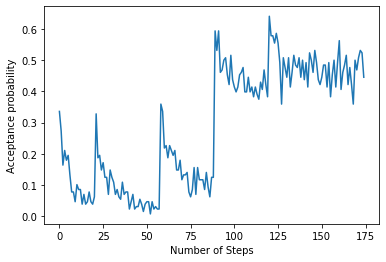

In [25]:
fig, ax = plt.subplots()

ax.plot(sampler.acceptance_fraction)
ax.set_xlabel('Number of Steps')
ax.set_ylabel('Acceptance probability')

plt.show()

In [26]:
sampler.acceptance_fraction[-5:] # last five acceptance probabilities 

array([0.46875  , 0.5078125, 0.53125  , 0.5234375, 0.4453125])

Running converged sampler for 64 steps and extract all samples from the posterior: 

In [27]:
%%time
# running converged sampler for 64 samples to obtain more points with 'accurate posterior probabilities'
outputs = sampler.run_mcmc(64)

CPU times: total: 26 s
Wall time: 26.2 s


In [28]:
# extracting all sample points from the posterior after burnin

samples = sampler.get_samples()

In [29]:
# computing the mean and 95% confidence intervals for c2 and alpha H 

c2_mean = samples[:, 2].mean()
print(c2_mean)

0.005405957014165349


In [30]:
c2_lower_bound = np.percentile(samples[:, 2], 2.5)
c2_upper_bound = np.percentile(samples[:, 2], 97.5)
print("Lower bound:", c2_lower_bound)
print("Upper bound:", c2_upper_bound)

Lower bound: 0.004827192609717541
Upper bound: 0.005991355681900445


In [31]:
alpha_h_mean = samples[:, 4].mean()
print(alpha_h_mean)

5.0176415180720575


In [32]:
alpha_h_lower = np.percentile(samples[:, 4], 2.5)
alpha_h_upper = np.percentile(samples[:, 4], 97.5)

print("Lower bound:", alpha_h_lower)
print("Upper bound:", alpha_h_upper)

Lower bound: 0.23648282107289975
Upper bound: 9.784569023358367


Plotting the mean and 95% confidence interval of the heat capacity (Cp) as a function of temperature (K) between 2500 and 5000K:

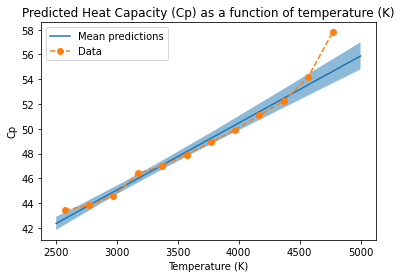

In [33]:
r = np.linspace(2500, 5000, 128)
cp_predictions = [spc(s[1], s[2], r) for s in samples]

fig, ax = plt.subplots()

# plotting mean of Cp
ax.plot(r, np.mean(cp_predictions, axis=0),label='Mean predictions')

# plotting 95% confidence interval 
ax.fill_between(r, np.percentile(cp_predictions, 2.5, axis=0), np.percentile(cp_predictions, 97.5, axis=0), alpha=0.5)

# plotting actual data points
ax.plot(cp_data['T'], cp_data['Cp'], '--o', label='Data')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Cp')
ax.set_title('Predicted Heat Capacity (Cp) as a function of temperature (K)')

ax.legend()

At intermediate temperatures (3500-4000K), the model consistently overestimates the heat capacity due to outliers at around 5000K in the original dataset. 

#### Increasing outlier sensitivity to analyze its relationship with model performance: 

Changing the 'logprob_cp_data' and 'logprob_h_data' functions from using normal distributions to a Student t distribution that is more sensitive to outliers. This Student t distribution is typically used in smaller datasets where the standard deviation may possible be unknown and includes a new parameter, df (degrees of freedom). I am using a relatively small df value of 2.1, which means the model will have heavier tails and contain more values farther away from the mean. 

In [34]:
class Posterior:
    """Posterior probability of liquid H thermodynamic models
    
    Assumes parameters are in the order: c_0, c_1, c_2, alpha_cp, alpha_h
    """
    
    def __init__(self, cp_data, h_data, priors):
        """Initialize the class
        
        Args:
            cp_data: Heat capacity data
            h_data: Enthalpy data
            prior: Prior distributions for each parameter
        """
        self.cp_data = cp_data
        self.h_data = h_data
        self.priors = priors
        
    def logprob_cp_data(self, params):
        """Compute the log probability of observing the C_p data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        ## taking the sum of the log-likelihoods of observing the model given parameters
        cp_pred = spc(params[1], params[2], cp_data['T'])
        cp_error = cp_data['Cp'] - cp_pred
        
        return stats.t(df=2.1, loc=0, scale=cp_data['sigma_Cp']).logpdf(cp_error).sum() # standard deviation determined by uncertainty value
    
    def logprob_h_data(self, params):
        """Compute the log probability of observing the H data
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of observing the data
        """
        
        ## taking the sum of the log-likelihoods of observing the model given parameters
        h_pred = enthalpy(params[0], params[1], params[2], h_data['T'])
        h_error = h_data['H'] - h_pred
        
        return stats.t(df=2.1, loc=0, scale=h_data['sigma_H']).logpdf(h_error).sum() # standard deviation determined by uncertainty value
        
    def logprob_prior(self, params):
        """Compute the log probability of the parameters given the prior distributions.
        
        Includes the prior for model parameters and the "dataset weights" (\alpha)
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the priors
        """
     ## taking the sum of the log-likelihoods of the parameters in the prior distribution
        logpdf_prior = 0
        for prior, x in zip(priors, params[:-2]): 
            logpdf_prior += prior.logpdf(x)
            
        return logpdf_prior + priors[3].logpdf(params[3]) + priors[4].logpdf(params[4])
            
    
    def __call__(self, params):
        """Compute the log posterior probability given the parameters
        
        Args:
            params ([float]): Chosen parameters
        Returns:
            Log-likelihood of the posterior
        """
        
        return self.logprob_cp_data(params) + self.logprob_prior(params) + self.logprob_h_data(params)

In [35]:
ln_posterior_new = Posterior(cp_data, h_data, priors)
ln_posterior_new([5000, 35, 0.005, 1, 1])

-340.8412740227875

Resampling 128 points from the prior distribution: 

In [36]:
n_walkers = 128

initial_p_new = np.vstack([p.rvs(size=(n_walkers,)) for p in priors]).T

Creating a new sampler with the new posterior function and burning it in again: 

In [37]:
sampler_new = kombine.Sampler(n_walkers, 5, ln_posterior_new, pool=kombine.serialpool.SerialPool()) ## including new posterior function

In [38]:
%%time
output = sampler_new.burnin(p0=initial_p_new) ## burning in new model 

CPU times: total: 1min 14s
Wall time: 1min 15s


In [39]:
%%time 
outputs = sampler_new.run_mcmc(64) ## running model for another 64 steps

CPU times: total: 25.9 s
Wall time: 26.3 s


In [40]:
samples_new = sampler_new.get_samples() ## extract all samples after burnin

Remeasuring the mean and confidence intervals of the c2 parameter: 

In [41]:
c2_mean_new = samples_new[:, 2].mean() 
print("Mean of c2 parameter after modification:", c2_mean_new) # slightly smaller than previously
print("Mean of c2 original parameter:", c2_mean)

Mean of c2 parameter after modification: 0.005286178403874457
Mean of c2 original parameter: 0.005405957014165349


In [42]:
c2_lower_new = np.percentile(samples_new[:, 2], 2.5)
c2_upper_new = np.percentile(samples_new[:, 2], 97.5)

print("Lower bound:", c2_lower_new)
print("Upper bound:", c2_upper_new) # slightly greater than previously 

print("Original lower bound:", c2_lower_bound)
print("Original upper bound:", c2_upper_bound)

Lower bound: 0.004687462073855566
Upper bound: 0.0058862359509507115
Original lower bound: 0.004827192609717541
Original upper bound: 0.005991355681900445


Replotting the mean and confidence intervals of heat capacity as a function of temperature: 

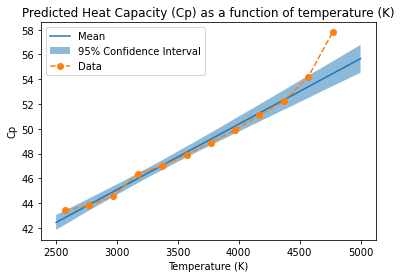

In [43]:
r_new = np.linspace(2500, 5000, 128)
cp_predictions_new = [spc(s[1], s[2], r_new) for s in samples_new]
                      
fig, ax = plt.subplots()

ax.plot(r, np.mean(cp_predictions_new, axis=0), label='Mean')

ax.fill_between(r, np.percentile(cp_predictions_new, 2.5, axis=0), np.percentile(cp_predictions_new, 97.5, axis=0), alpha=0.5, label='95% Confidence Interval')
        
ax.plot(cp_data['T'], cp_data['Cp'], '--o', label='Data')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Cp')
ax.set_title('Predicted Heat Capacity (Cp) as a function of temperature (K)')

ax.legend()

#### Comparing error of two models: 

In [44]:
%%time 
log_evidence = [Posterior.logprob_cp_data(ln_posterior, [*s]) for s in samples] # calculating posterior probabilities of the original model

CPU times: total: 4.3 s
Wall time: 4.35 s


In [45]:
%%time 
log_evidence_new = [Posterior.logprob_cp_data(ln_posterior_new, [*s]) for s in samples_new] # calculating posterior probabilities of the new model

CPU times: total: 3.88 s
Wall time: 3.99 s


Calculating the marginal likelihood of both models (seeing how well the model fits the data by computing the integral of the posterior distributions):

In [46]:
evidence = np.logaddexp.reduce(log_evidence) - np.log(len(samples)) # taking the average of the total sum of all the log-likelihoods 
print("Log model evidence is:", evidence)

Log model evidence is: -13.611243452873627


In [47]:
evidence_new = np.logaddexp.reduce(log_evidence_new) - np.log(len(samples_new))
print("Log model evidence is:", evidence_new)

Log model evidence is: -13.69362120154262


Calculating the Bayes factor (ratio of the posterior probability of each model)

In [48]:
bayes_factor = np.exp(evidence_new - evidence)
print("The Bayes Factor for the new and original models is", bayes_factor)

The Bayes Factor for the new and original models is 0.9209240151619118


#### Conclusions:
1. As we increase the model's robustness to outliers, its overall performance decreased due to the size of our dataset. Because it was small, outliers can drastically influence model accuracy, thus exasterbating existing systematic errors. 

2. Bayesian methods can be effective at comparing multiple models and analyzing the influence of a particular parameter on overall model performance and accuracy. By establishing prior and likelihood distributions/functions, we can compute the posterior probabilities of each model and calculate its Bayes factor. Using logarithms is important as computer struggle to multiply and divide large numbers. 


Note to myself: gain more experience with kombine!!